In [ ]:
import nbimporter
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import Tuple, Callable
from skopt import gp_minimize
from skopt.space import Integer, Categorical, Real
from sklearn.metrics import r2_score
import torch.nn as nn
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from dataloader import load_dataset, get_cryptoquant_data, combineTA_to_OHLCV

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, data_min, data_max, scaler = load_dataset()

In [3]:
print(f"X train shape:{X_train_tensor.shape}")
print(f"X test shape:{X_test_tensor.shape}")
print(f"y train shape:{y_train_tensor.shape}")
print(f"y test shape:{y_test_tensor.shape}")

X train shape:(36753, 20, 8)
X test shape:(15752, 20, 8)
y train shape:(36753, 8)
y test shape:(15752, 8)


In [4]:
# Create a function to time our experiments
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout_prob: float = 0.2):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob
        )

        # Attention mechanism
        self.attn_weight = nn.Linear(hidden_size, 1)

        # Output layer: now outputs 8 features
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, input_size),  # output 8 features
            # nn.Sigmoid()  # Uncomment this ONLY if you want outputs in range [0, 1]
        )

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        batch_size = x.shape[0]

        # Initialize hidden and cell states
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        # LSTM output
        lstm_out, _ = self.lstm(x, (h_0, c_0))  # [batch, seq_len, hidden_size]

        # Attention mechanism
        attn_scores = torch.tanh(self.attn_weight(lstm_out))  # [batch, seq_len, 1]
        attn_weights = F.softmax(attn_scores, dim=1)  # [batch, seq_len, 1]
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)  # [batch, hidden_size]

        # Dropout + final output
        out = self.dropout(context_vector)
        out = self.fc(out)  # [batch, 8]
        return out



In [6]:
torch.manual_seed(42)
# Instantiate a sample model for test
model_LSTM = AttentionLSTM(input_size=8, hidden_size=33, num_layers=3, dropout_prob=0.02)

In [7]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr= 0.0003)

In [8]:
def regression_r2(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()

    # Compute R² for each feature separately and average
    r2_scores = [r2_score(y_true_np[:, i], y_pred_np[:, i]) for i in range(y_true_np.shape[1])]
    return torch.tensor(sum(r2_scores) / len(r2_scores))


In [9]:
import torch
from typing import Tuple, Callable
import matplotlib.pyplot as plt


def recursive_forecast(
    model: torch.nn.Module,
    initial_input: torch.Tensor,
    forecast_steps: int,
    lookback: int,
    device: torch.device
) -> torch.Tensor:
    """
    Recursively forecasts future multi-feature values using the trained LSTM model.

    Args:
        model: Trained LSTM model
        initial_input: Tensor of shape [1, lookback, num_features]
        forecast_steps: Number of future steps to predict
        lookback: Length of input window
        device: CPU or CUDA

    Returns:
        forecast: Tensor of shape [forecast_steps, output_dim]
    """
    model.eval()
    forecast = []

    current_input = initial_input.clone().to(device)

    with torch.inference_mode():
        for _ in range(forecast_steps):
            pred = model(current_input)  # [1, output_dim] -> [1, 8]
            forecast.append(pred.squeeze(0))  # [8]

            # Replace last step with predicted features
            new_step = pred.unsqueeze(1)  # [1, 1, 8]
            current_input = torch.cat([current_input[:, 1:], new_step], dim=1)  # slide window

    return torch.stack(forecast)  # [forecast_steps, 8]


def evaluate_forecast(
    forecast: torch.Tensor,
    ground_truth: torch.Tensor,
    loss_fn: torch.nn.Module,
    metrics_fn: Callable[[torch.Tensor, torch.Tensor], float] = None
) -> Tuple[float, float]:
    """
    Compares forecast with ground truth and computes evaluation metrics.

    Args:
        forecast: Tensor of predicted values [forecast_steps, output_dim]
        ground_truth: Tensor of true values [forecast_steps, output_dim]
        loss_fn: Loss function (e.g. MSE)
        metrics_fn: Optional function to compute additional metrics like R^2

    Returns:
        loss_value, metrics_value
    """
    loss_value = loss_fn(forecast, ground_truth).item()
    metrics_value = metrics_fn(forecast, ground_truth).item() if metrics_fn else None
    return loss_value, metrics_value



In [10]:
from sklearn.metrics import r2_score
import torch.nn as nn

def run_training_and_testing(
    model: torch.nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    lookback: int,
    device: torch.device,
    epochs: int = 100,
    lr: float = 0.001,
):
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    # Define loss and optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    # Begin training loop
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()

        # Forward pass
        y_pred_train = model(X_train)
        train_loss = loss_fn(y_pred_train, y_train)

        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Evaluate every 20 epochs
        if epoch % 20 == 0 or epoch == epochs:
            with torch.inference_mode():
                # Forecast using recursive strategy
                initial_input = X_test[0].unsqueeze(0)  # [1, lookback, features]
                forecast_steps = len(y_test)
                y_pred_test = recursive_forecast(model, initial_input, forecast_steps, lookback, device)

                # Evaluate y_pred_test
                test_loss, test_r2 = evaluate_forecast(y_pred_test, y_test[:forecast_steps], loss_fn, regression_r2)

                print(f"Epoch [{epoch}/{epochs}]")
                print(f"  Train Loss: {train_loss.item():.5f}")
                print(f"  Test Loss:  {test_loss:.5f} | R² Score: {test_r2:.4f}")

    return model, y_pred_train, y_pred_test, train_loss, test_loss, test_r2


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Measure time
from timeit import default_timer as timer
train_time_start_model_0 = timer()

trained_model, y_pred_train, y_pred_test, train_loss, test_loss, test_r2 = run_training_and_testing(
    model=model_LSTM,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    lookback=20,
    device=device,
    epochs=100
)

train_time_end_model_0 = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_model_0,
                                            end=train_time_end_model_0,
                                            device=device)


 20%|██        | 20/100 [01:38<12:01,  9.02s/it]

Epoch [20/100]
  Train Loss: 0.03629
  Test Loss:  0.05851 | R² Score: -28914720.0000


 40%|████      | 40/100 [03:16<09:21,  9.35s/it]

Epoch [40/100]
  Train Loss: 0.00667
  Test Loss:  0.02578 | R² Score: -95352184.0000


 60%|██████    | 60/100 [04:54<05:57,  8.94s/it]

Epoch [60/100]
  Train Loss: 0.00489
  Test Loss:  0.02378 | R² Score: -68022696.0000


 80%|████████  | 80/100 [06:34<03:04,  9.25s/it]

Epoch [80/100]
  Train Loss: 0.00472
  Test Loss:  0.02315 | R² Score: -386551488.0000


100%|██████████| 100/100 [08:21<00:00,  5.01s/it]

Epoch [100/100]
  Train Loss: 0.00464
  Test Loss:  0.02320 | R² Score: -249687376.0000
Train time on cpu: 501.494 seconds


In [12]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def denormalize(data, scaler: MinMaxScaler) -> np.ndarray:
    """
    Denormalizes data using the given scaler.

    Args:
        data (torch.Tensor or np.ndarray): Normalized data
        scaler (MinMaxScaler): Scaler used during normalization

    Returns:
        np.ndarray: Denormalized data
    """
    if isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()
    return scaler.inverse_transform(data)



In [13]:
# Denormalize true and predicted values
y_train_true_denorm = denormalize(y_train_tensor, scaler)
y_train_pred_denorm = denormalize(y_pred_train, scaler)

y_test_true_denorm = denormalize(y_test_tensor, scaler)
y_test_pred_denorm = denormalize(y_pred_test, scaler)


In [14]:
from skopt import gp_minimize
from skopt.space import Integer, Categorical
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the objective function for Bayesian Optimization
def objective(params):
    # Extract parameters
    num_layers = int(params[0])
    hidden_size = int(params[1])
    lookback = int(params[2])
    batch_size_bo = int(params[3])
    optimizer_name = params[4]

    X_train_t = torch.FloatTensor(X_train_tensor)
    y_train_t = torch.FloatTensor(y_train_tensor)
    X_test_t = torch.FloatTensor(X_test_tensor)
    y_test_t = torch.FloatTensor(y_test_tensor)
    
    # Model initialization
    model = AttentionLSTM(
        input_size=8,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout_prob=0.2  # Fixed dropout
    ).to(device)
    
    # Optimizer selection
    if optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif optimizer_name == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters())
    
    # Training loop (limited epochs for optimization)
    model.train()
    batch_size_bo = 32
    for epoch in range(10):  # Reduced epochs for faster optimization
        for i in range(0, len(X_train_t), batch_size_bo):
            inputs = X_train_t[i:i+batch_size_bo].to(device)
            labels = y_train_t[i:i+batch_size_bo].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        test_preds = recursive_forecast(
            model, 
            X_test_t[0:1],  # Initial sequence
            len(X_test_t),
            lookback,
            device
        )
        val_loss = nn.MSELoss()(test_preds, y_test_t).item()
    
    return val_loss

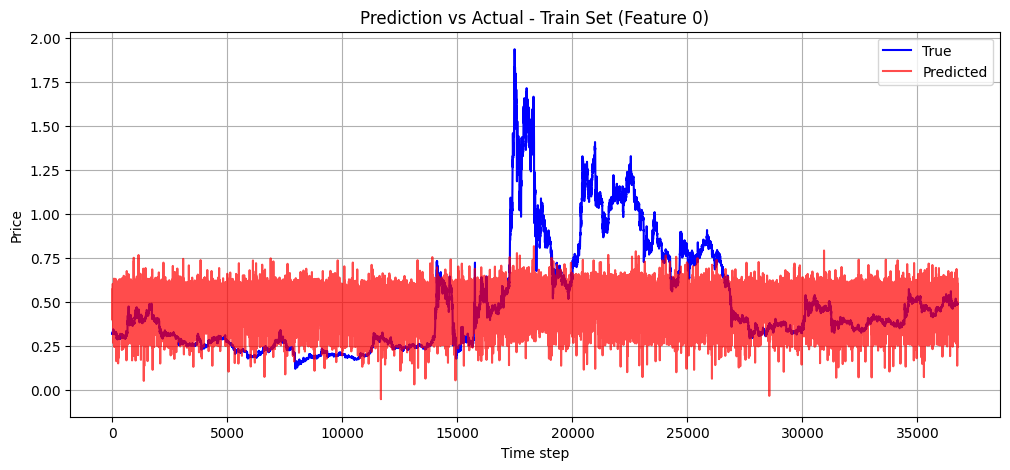

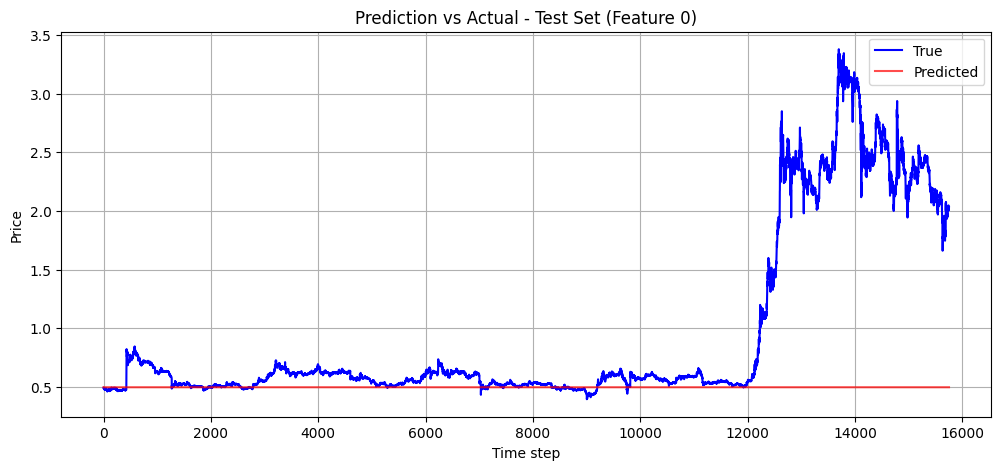

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(true_vals, predicted_vals, title='Prediction vs Actual', feature_idx=0, dataset_type='Train'):
    plt.figure(figsize=(12, 5))
    plt.plot(true_vals[:, feature_idx], label='True', color='blue')
    plt.plot(predicted_vals[:, feature_idx], label='Predicted', color='red', alpha=0.7)
    plt.title(f'{title} - {dataset_type} Set (Feature {feature_idx})')
    plt.xlabel('Time step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Plot for 'close' price (assuming it's feature 0)
plot_predictions(y_train_true_denorm, y_train_pred_denorm, dataset_type='Train', feature_idx=0)
plot_predictions(y_test_true_denorm, y_test_pred_denorm, dataset_type='Test', feature_idx=0)


In [16]:
# Define search space
param_space = [
    Integer(1, 3, name='num_layers'),          # LSTM layers
    Integer(32, 256, name='hidden_size'),      # Hidden units
    Integer(60, 90, name='lookback'),          # Sequence length
    Integer(32, 256, name='batch_size'),       # Batch size
    Categorical(['adam', 'rmsprop'], name='optimizer')  # Optimizer
]

In [17]:
# Run optimization
res = gp_minimize(
    objective,
    param_space,
    n_calls=20,               # Reduced from 30
    random_state=42,
    verbose=True,
    n_jobs=-1                # Parallel processing
)

# Best parameters
print(f"Best parameters: {res.x}")
print(f"Best validation MSE: {res.fun}")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 180.4019
Function value obtained: 0.0235
Current minimum: 0.0235
Iteration No: 2 started. Evaluating function at random point.


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 92.9949
Function value obtained: 0.0234
Current minimum: 0.0234
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 140.3298
Function value obtained: 0.0229
Current minimum: 0.0229
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 372.5308
Function value obtained: 0.0233
Current minimum: 0.0229
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 93.6085
Function value obtained: 0.0232
Current minimum: 0.0229
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 192.4067
Function value obtained: 0.0235
Current minimum: 0.0229
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Eval

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(true_vals, predicted_vals, title='Prediction vs Actual', feature_idx=0, dataset_type='Train'):
    plt.figure(figsize=(12, 5))
    plt.plot(true_vals[:375, feature_idx], label='True', color='blue')
    plt.plot(predicted_vals[:375, feature_idx], label='Predicted', color='red', alpha=0.7)
    plt.title(f'{title} - {dataset_type} Set (Feature {feature_idx})')
    plt.xlabel('Time step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Plot for 'close' price (assuming it's feature 0)
plot_predictions(y_train_true_denorm, y_train_pred_denorm, dataset_type='Train', feature_idx=0)
plot_predictions(y_test_true_denorm, y_test_pred_denorm, dataset_type='Test', feature_idx=0)
